# Storage KPIs example plot

In [1]:
import lithops
import requests
import os
import time
import pylab
import logging
import numpy as np
import pandas as pd
import seaborn as sns
import uuid
from matplotlib.collections import LineCollection

from util import RandomDataGenerator

In [2]:
%matplotlib inline

In [4]:
STORAGE_BUCKET='aitor-us-south'
OBJ_SIZE_MB=256
N_KEYS=25
PREFIX='bin_data/'

In [5]:
fexec = lithops.FunctionExecutor()
storage = lithops.storage.Storage()

2022-05-27 16:03:54,755 [INFO] lithops.config -- Lithops v2.6.0
2022-05-27 16:03:54,755 [DEBUG] lithops.config -- Loading configuration from /home/aitor/Projects/lithops-github/lithops/.lithops_config
2022-05-27 16:03:54,764 [DEBUG] lithops.config -- Loading Serverless backend module: ibm_cf
2022-05-27 16:03:54,818 [DEBUG] lithops.config -- Loading Storage backend module: ibm_cos
2022-05-27 16:03:54,842 [DEBUG] lithops.storage.backends.ibm_cos.ibm_cos -- Creating IBM COS client
2022-05-27 16:03:54,843 [DEBUG] lithops.storage.backends.ibm_cos.ibm_cos -- Set IBM COS Endpoint to https://s3.us-south.cloud-object-storage.appdomain.cloud
2022-05-27 16:03:54,843 [DEBUG] lithops.util.ibm_token_manager -- Using IBM COS API Key - Reusing Token from local cache
2022-05-27 16:03:54,846 [DEBUG] lithops.util.ibm_token_manager -- Token expiry time: 2022-05-27 16:16:25.457115+02:00 - Minutes left: 12
2022-05-27 16:03:54,878 [INFO] lithops.storage.backends.ibm_cos.ibm_cos -- IBM COS client created - Re

In [6]:
def storage_performance(key_name, storage):
    # Write object
    generator = RandomDataGenerator(OBJ_SIZE_MB * 1024**2)
    data = generator.read()
    put_sz = len(data)  # get the size in bytes of the data to upload
    put_t0 = time.time()
    storage.put_object(STORAGE_BUCKET, key_name, data)
    put_t1 = time.time()
    write_bandwidth_mb = put_sz / (put_t1 - put_t0) / 1e6
    
    time.sleep(10) # simulate work...
    
    # Read object
    get_t0 = time.time()
    obj = storage.get_object(STORAGE_BUCKET, key_name)
    get_t1 = time.time()
    get_sz = len(obj)
    read_bandwidth_mb = get_sz / (get_t1 - get_t0) / 1e6
    
    stats = {
        'put': {'t0': put_t0, 't1': put_t1, 'bandwidth': write_bandwidth_mb, 'size': put_sz},
        'get': {'t0': get_t0, 't1': get_t1, 'bandwidth': read_bandwidth_mb, 'size': get_sz},
    }

    return stats

In [7]:
keynames = [PREFIX + str(uuid.uuid4().hex) for _ in range(N_KEYS)]

fexec = lithops.FunctionExecutor()
fs = fexec.map(storage_performance, keynames)
results = fexec.get_result(fs=fs)

2022-05-27 16:03:54,919 [INFO] lithops.config -- Lithops v2.6.0
2022-05-27 16:03:54,919 [DEBUG] lithops.config -- Loading configuration from /home/aitor/Projects/lithops-github/lithops/.lithops_config
2022-05-27 16:03:54,929 [DEBUG] lithops.config -- Loading Serverless backend module: ibm_cf
2022-05-27 16:03:54,929 [DEBUG] lithops.config -- Loading Storage backend module: ibm_cos
2022-05-27 16:03:54,930 [DEBUG] lithops.storage.backends.ibm_cos.ibm_cos -- Creating IBM COS client
2022-05-27 16:03:54,930 [DEBUG] lithops.storage.backends.ibm_cos.ibm_cos -- Set IBM COS Endpoint to https://s3.us-south.cloud-object-storage.appdomain.cloud
2022-05-27 16:03:54,931 [DEBUG] lithops.util.ibm_token_manager -- Using IBM COS API Key - Reusing Token from local cache
2022-05-27 16:03:54,933 [DEBUG] lithops.util.ibm_token_manager -- Token expiry time: 2022-05-27 16:16:25.457115+02:00 - Minutes left: 12
2022-05-27 16:03:54,936 [INFO] lithops.storage.backends.ibm_cos.ibm_cos -- IBM COS client created - Re

In [8]:
# results

In [9]:
read_results = [stat['get'] for stat in results]
write_results = [stat['put'] for stat in results]

In [12]:
def create_agg_bdwth_plot(res_write, res_read, dst):
    def compute_times_rates(start_time, d):
        x = np.array(d)
        tzero = start_time
        tr_start_time = x[:, 0] - tzero
        tr_end_time = x[:, 1] - tzero
        rate = x[:, 2]

        N = len(tr_start_time)
        runtime_rate_hist = np.zeros((N, len(runtime_bins)))

        for i in range(N):
            s = tr_start_time[i]
            e = tr_end_time[i]
            a, b = np.searchsorted(runtime_bins, [s, e])
            if b-a > 0:
                runtime_rate_hist[i, a:b] = rate[i]

        return {'start_time': tr_start_time,
                'end_time': tr_end_time,
                'rate': rate,
                'runtime_rate_hist': runtime_rate_hist}
    
    start_time = min((min(t['t0'] for t in res_write), (min(t['t0'] for t in res_read)))) - 1

    fig = pylab.figure(figsize=(8, 6))
    ax = fig.add_subplot(1, 1, 1)
    for datum, l in [(res_write, 'Aggregate Write Bandwidth'), (res_read, 'Aggregate Read Bandwidth')]:
        mb_rates = [(res['t0'], res['t1'], res['bandwidth']) for res in datum]
        max_seconds = int(max([mr[1]-start_time for mr in mb_rates])*1.2)
        max_seconds = 8 * round(max_seconds/8)
        runtime_bins = np.linspace(0, max_seconds, max_seconds)

        mb_rates_hist = compute_times_rates(start_time, mb_rates)

        ax.plot(mb_rates_hist['runtime_rate_hist'].sum(axis=0)/1000, label=l)

    ax.set_xlabel('Execution Time (sec)')
    ax.set_ylabel("GB/sec")
    ax.set_xlim(0, )
    ax.set_ylim(0, )
    pylab.legend()
    pylab.grid(True, axis='y')

    dst = os.path.expanduser(dst) if '~' in dst else dst

    fig.tight_layout()
    fig.savefig(dst, format='pdf')

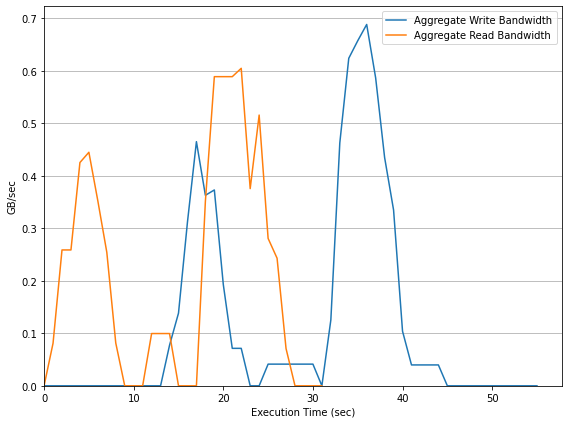

In [13]:
create_agg_bdwth_plot(read_results, write_results, fexec.executor_id + '-storage-kpi')

In [14]:
keys = storage.list_keys(bucket=STORAGE_BUCKET, prefix=PREFIX)

In [15]:
for key in keys:
    storage.delete_object(bucket=STORAGE_BUCKET, key=key)